In [3]:

import warnings
warnings.simplefilter(action='ignore') # , category=FutureWarning)

from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

import itertools

from collections import OrderedDict

import gridop as gop
import diags as dg
import plot as cplt
from model import Model
from tools import wait_cluster_ready

# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 10
# fig_size[1] = 8
# plt.rcParams["figure.figsize"] = fig_size

### Launch dask cluster

In [4]:
from dask.distributed import Client, LocalCluster

# number of cores per node
workers_per_job = 4
# number of nodes
jobs = 2
nworkers = workers_per_job * jobs

# pour 1 seul noeud
# cluster = LocalCluster(n_workers=2, threads_per_worker=2)

# pour plusieurs noeuds:
# ** processes and cores may be adjusted in order to have more memory 
# or inversely more computational ressource
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=workers_per_job, cores=workers_per_job, walltime='02:00:00')
w = cluster.scale(jobs=jobs)
#cluster.adapt(minimum=1, maximum=5)

client = Client(cluster)
wait_cluster_ready(cluster, nworkers)
client

100 % of the workers started: 8 workers


<Client: 'tcp://10.148.0.147:51276' processes=8 threads=8, memory=223.52 GiB>

---
### Parameters

In [5]:
# Initialisation gigatl3
path = '/home/datawork-lops-megatl/GIGATL3/GIGATL3_1h/HIS/'
filenames = [path+'GIGATL3_12h_inst_2012-07-16-2012-07-20.nc']
gridname  = '/home/datawork-lops-megatl/GIGATL3/gigatl3_grid.nc'
suffix=''
longitude = -35.
latitude = 10.
depth = -10.
# deltat = None
seldate = '2012-07-16'

--- 
### Create an instance of the Model class 
which contains all the substitutions of the variables names depending on the model: 
- croco_xios

In [6]:
croco = Model("croco_xios")

### Open all the data files and the grid file and return a dataset. Create the xgcm grid.

In [7]:
%%time
drop_variables = ['time', 'nav_lon_w', 'nav_lat_w',
                  'sustr', 'svstr','bvf',
                  'hc','h','Vtransform','sc_r','sc_w',
                  'Cs_r','Cs_w','angle','mask_rho',
                  'pm','pn','Tcline','theta_s','theta_b',
                  'lon_rho','lat_rho','lon_u','lat_u','lon_v','lat_v',
                  'nav_lon_rho','nav_lat_rho','nav_lon_u','nav_lat_u','nav_lon_v','nav_lat_v',
                  'time_instant','time_instant_bounds',
                  'time_counter_bounds',
                 ]
ds, grid = gop.open_files(croco, gridname, filenames, grid_metrics=1, 
                          drop_variables=drop_variables, suffix=suffix,
                          chunks={'t':1, 's':1, 's_w':1},
                         )

CPU times: user 2.14 s, sys: 1.37 s, total: 3.51 s
Wall time: 3.59 s


In [8]:
croco.toto()

<xarray.Dataset>
Dimensions:      (s: 100, s_w: 101, t: 10, y: 4002, x: 3002, x_u: 3001,
                  y_v: 4001)
Coordinates:
  * s            (s) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w          (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
  * t            (t) datetime64[ns] 2012-07-16T12:00:00 ... 2012-07-21
    lat          (y, x) float32 dask.array<chunksize=(4002, 3002), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(4002, 3002), meta=np.ndarray>
    lon_u        (y, x_u) float32 dask.array<chunksize=(4002, 3001), meta=np.ndarray>
    lat_u        (y, x_u) float32 dask.array<chunksize=(4002, 3001), meta=np.ndarray>
    lon_v        (y_v, x) float32 dask.array<chunksize=(4001, 3002), meta=np.ndarray>
    lat_v        (y_v, x) float32 dask.array<chunksize=(4001, 3002), meta=np.ndarray>
    lon_f        (y_v, x_u) float32 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
    lat_f        (y_v, x_u) float32 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v
Data variables: (12/33)
    z_sfc        (t, y, x) float32 dask.array<chunksize=(1, 4002, 3002), meta=np.ndarray>
    xcur_btrope  (t, y, x_u) float32 dask.array<chunksize=(1, 4002, 3001), meta=np.ndarray>
    ycur_btrope  (t, y_v, x) float32 dask.array<chunksize=(1, 4001, 3002), meta=np.ndarray>
    xcur         (t, s, y, x_u) float32 dask.array<chunksize=(1, 1, 4002, 3001), meta=np.ndarray>
    ycur         (t, s, y_v, x) float32 dask.array<chunksize=(1, 1, 4001, 3002), meta=np.ndarray>
    zcur         (t, s, y, x) float32 dask.array<chunksize=(1, 1, 4002, 3002), meta=np.ndarray>
    ...           ...
    dx_psi       (y_v, x_u) float32 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
    dy_psi       (y_v, x_u) float32 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
    rAr          (y_v, x_u) float32 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
    rAu          (y_v, x) float32 dask.array<chunksize=(4001, 3002), meta=np.ndarray>
    rAv          (y, x_u) float32 dask.array<chunksize=(4002, 3001), meta=np.ndarray>
    rAf          (y, x) float32 dask.array<chunksize=(4002, 3002), meta=np.ndarray>
Attributes: (12/45)
    name:           ./HIS/GIGATL3_12h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    timeStamp:      2020-Mar-23 20:01:13 GMT
    uuid:           c2218514-a5e9-40af-ab90-2e812bec3d99
    title:          GIGATL3
    ...             ...
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GIGATL3 MPI_TIME MPI XIOS XIOS2 OBC_EAST OBC_NOR...
    sc_w:           [-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0...
    Cs_w:           [-1.00000000e+00 -9.83735238e-01 -9.66697847e-01 -9.48934...
    sc_r:           [-0.995 -0.985 -0.975 -0.965 -0.955 -0.945 -0.935 -0.925 ...
    Cs_r:           [-9.91966929e-01 -9.75310303e-01 -9.57903911e-01 -9.39797...

In [11]:
%%time
# ds1 = ds.isel(t=indxdate)
ds1 = ds.sel(t=seldate, method='nearest')
ds1 = gop.auto_chunk(ds1, keep_complete_dim='s', wanted_chunk=200)
ds1

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 50.5 ms


<xarray.Dataset>
Dimensions:      (s: 100, s_w: 101, y: 4002, x: 3002, x_u: 3001, y_v: 4001)
Coordinates:
  * s            (s) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w          (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    t            datetime64[ns] 2012-07-16T12:00:00
    lat          (y, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    lon_u        (y, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    lat_u        (y, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    lon_v        (y_v, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    lat_v        (y_v, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    lon_f        (y_v, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    lat_f        (y_v, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v
Data variables: (12/33)
    z_sfc        (y, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    xcur_btrope  (y, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    ycur_btrope  (y_v, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    xcur         (s, y, x_u) float32 dask.array<chunksize=(100, 166, 3001), meta=np.ndarray>
    ycur         (s, y_v, x) float32 dask.array<chunksize=(100, 166, 3002), meta=np.ndarray>
    zcur         (s, y, x) float32 dask.array<chunksize=(100, 166, 3002), meta=np.ndarray>
    ...           ...
    dx_psi       (y_v, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    dy_psi       (y_v, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    rAr          (y_v, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    rAu          (y_v, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    rAv          (y, x_u) float32 dask.array<chunksize=(166, 3001), meta=np.ndarray>
    rAf          (y, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
Attributes: (12/45)
    name:           ./HIS/GIGATL3_12h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    timeStamp:      2020-Mar-23 20:01:13 GMT
    uuid:           c2218514-a5e9-40af-ab90-2e812bec3d99
    title:          GIGATL3
    ...             ...
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GIGATL3 MPI_TIME MPI XIOS XIOS2 OBC_EAST OBC_NOR...
    sc_w:           [-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0...
    Cs_w:           [-1.00000000e+00 -9.83735238e-01 -9.66697847e-01 -9.48934...
    sc_r:           [-0.995 -0.985 -0.975 -0.965 -0.955 -0.945 -0.935 -0.925 ...
    Cs_r:           [-9.91966929e-01 -9.75310303e-01 -9.57903911e-01 -9.39797...

### U slice at a constant depth

KilledWorker: ("('open_dataset-4265a7243be52ae97c6f013f589b5fb1u-7d3e324099e90a7818d53110bec2d360', 0, 0, 0, 0)", <WorkerState 'tcp://10.148.0.244:45349', name: PBSCluster-0-1, status: closed, memory: 0, processing: 15>)

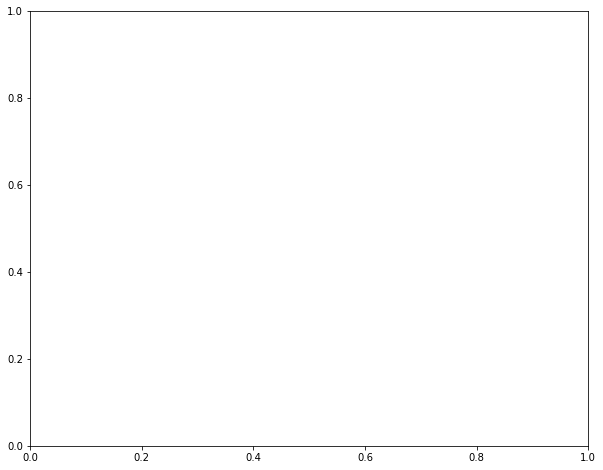

In [12]:
%%time
# depths at u points
z_u = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='u')
# slice of u at a constant depth
uslice= gop.slices(croco, ds1.xcur, z_u, ds=ds1, depth=depth)# .compute()
# plot the slice of u
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(uslice, **kwargs)
# coords = gop.get_spatial_coords(uslice)
# uslice.plot(x=coords['lon'], y=coords['lat'], cmap='seismic', vmin=-1.5, vmax=1.5)
# plt.savefig('u_'+case+'.png', bbox_inches = 'tight')

In [11]:
v=ds1.ycur
v=gop.auto_chunk(v, keep_complete_dim='s', wanted_chunk=200)
v

<xarray.DataArray 'ycur' (s: 100, y_v: 4001, x: 3002)>
dask.array<rechunk-merge, shape=(100, 4001, 3002), dtype=float32, chunksize=(100, 166, 3002), chunktype=numpy.ndarray>
Coordinates:
  * s        (s) float32 -0.995 -0.985 -0.975 -0.965 ... -0.025 -0.015 -0.005
    t        datetime64[ns] 2012-07-16T12:00:00
    lon_v    (y_v, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
    lat_v    (y_v, x) float32 dask.array<chunksize=(166, 3002), meta=np.ndarray>
Dimensions without coordinates: y_v, x
Attributes:
    long_name:           v-momentum component
    units:               meter second-1
    online_operation:    instant
    interval_operation:  12 h
    interval_write:      12 h
    cell_methods:        time: point

### V slice at a constant depth

In [13]:
%%time
# depth at v points
z_v = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, hgrid='v')
# slice of v at a constant depth
v=ds1.ycur
v=gop.auto_chunk(v, keep_complete_dim='s', wanted_chunk=200)
vslice= gop.slices(croco, v, z_v, ds=ds1, depth=depth).compute()
# plot the v slice
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(vslice, **kwargs)
# coords = gop.get_spatial_coords(vslice)
# vslice.plot(x=coords['lon'], y=coords['lat'], cmap='seismic', vmin=-2, vmax=2
#            )
# ax = plt.gca()
# ax.set_facecolor('white')
# plt.savefig('v_'+case+'.png', bbox_inches = 'tight')

ValueError: dimension s on 1th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(s=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

### Rotate u,v to lat,lon coord

In [89]:
%%time
# depth at rho points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
aslice= ds1.angle.compute()
# compute u_EW and v_SN
[urot,vrot] = gop.rotuv(croco, ds1, u=uslice, v=vslice, angle=aslice)
# plot rotated u
# coords = gop.get_spatial_coords(urot)
# urot.plot(x=coords['lon'], y=coords['lat'], cmap='coolwarm_r')

CPU times: user 147 ms, sys: 17.2 ms, total: 164 ms
Wall time: 178 ms


### Compute relative vorticity

CPU times: user 2.32 s, sys: 72.9 ms, total: 2.39 s
Wall time: 2.39 s


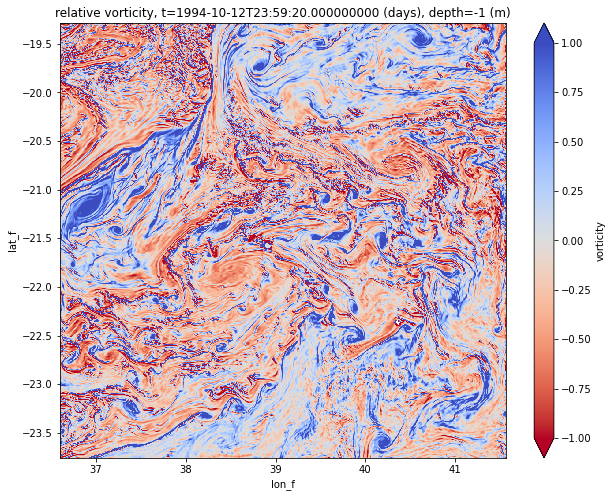

In [90]:
%%time
# compute the relative vorticity at a constant depth
relvort = dg.relative_vorticity(croco, ds=ds1, xgrid=grid, u=uslice, v=vslice)
# plot the relative vorticity
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(relvort, **kwargs)
# coords = gop.get_spatial_coords(relvort)
# relvort.plot(x=coords['lon'], y=coords['lat'], cmap='coolwarm_r', vmin=-1, vmax=1)
# #plt.title('relative vorticity, t='+ds1.t+' (days), depth='+depth+' (m)')
# plt.title('relative vorticity, t='+str(ds1.t.values)+' (days), depth='+str(depth)+' (m)')
# plt.savefig('relvort_'+case+'.png', dpi=300, bbox_inches = 'tight')

### Compute dtemp/dz on a longitudinal slice

CPU times: user 2.21 s, sys: 234 ms, total: 2.44 s
Wall time: 1min 10s


/home1/datahome/slgentil/conda-env/croco/lib/python3.8/site-packages/xarray/core/dataarray.py:682: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


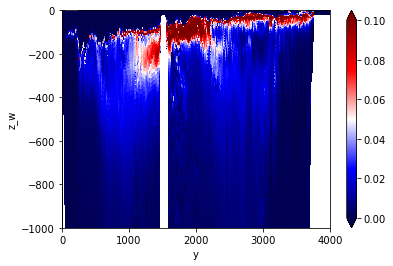

In [23]:
%%time
# longitudinal slice of temperature
tslice = gop.slices(croco, ds1.temp, z, ds=ds1, longitude=longitude).compute()
# compute dtemp/dz
dtdz = st.dtempdz(croco, ds=ds1, temp=tslice, z=tslice.z)
# plot dtemp/dz
coords = gop.get_spatial_coords(dtdz)
dtdz.plot(x=coords['lat'], y=coords['z'], ylim=[-1000,0], vmin=0, vmax=0.1, cmap="seismic")

### Compute Richardson on a longitudinal slice

9.81
CPU times: user 8.45 s, sys: 1.14 s, total: 9.6 s
Wall time: 3min 32s


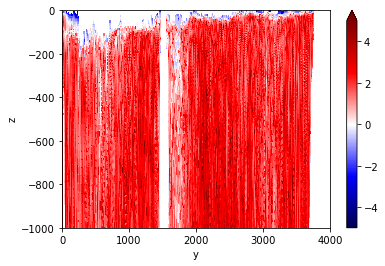

In [12]:
%%time
# longitudinal slices of rho,u,v
rslice = gop.slices(croco, ds1.rho, z, ds=ds1, longitude=longitude).compute()
uslice = gop.slices(croco, ds1.xcur, z_u, ds=ds1, longitude=longitude).compute()
vslice = gop.slices(croco, ds1.ycur, z_v, ds=ds1, longitude=longitude).compute()
# compute the Richardson number
Ri = st.richardson(croco, ds=ds1, u=uslice, v=vslice, rho=rslice, z=rslice.z)
# plot the Richardson number
coords = gop.get_spatial_coords(Ri)
Ri.plot(x=coords['lat'], y=coords['z'], ylim=[-1000,0], vmin=-5, vmax=5, cmap="seismic")

### Compute the Pressure

In [ ]:
%%time
# depth at rho points and w points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
z_w = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='w')
# compute the pressure
P = dg.get_p(croco, ds1.rho, z_w, z, ds=ds1)
# plot the pressure
coords = gop.get_spatial_coords(P)
P.isel(y=int(P.y.size/8)).plot(x=coords['lon'], y=coords['z'], cmap="seismic")

In [22]:
%%time
if False:
    pv = ertel_pv(croco, ds=ds1, typ='ijk')
    pv.isel(s_w=-1).plot(x=coords['lon'], y=coords['lat'], vmin=-4e-3, vmax=4e-3, cmap="seismic")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [25]:
from scipy.sparse import lil_matrix
from pyamg import ruge_stuben_solver, solve       


def streamfunction(model, pv, ds=None, pm=None, pn=None, xgrid=None):
    """
    Compute the stream function from the relative vorticity
    Invert the laplacian to solve the poisson equation Ax=b
    A is the horizontal laplacian, b is the vorticity
    Input:
        - pm : (DataArray) 1/dx metric
        - pn : (DataArray) 1/dy metric
        - pv : (DataArray) relative vorticity
        - verbo : (Boolean) verbose mode
    Output:
        (DataArray) the computed streamfunction 
    """

    if xgrid is None: xgrid=model.xgrid
    if ds is None: ds=model.ds
        
    if pm is None:
        try: 
            pm=ds.pm
        except:
            print("pm not found in the dataset")
            return None
    if pn is None:
        try: 
            pn=ds.pn
        except:
            print("pn not found in the dataset")
            return None
        
    if np.any(np.isnan(pv)): 
        print("Can't inverse the laplacian, non compact domain, pv contains nan values")
        return None

    #######################################################
    #Create matrix A
    #######################################################
    A = poisson_matrix(pm.values,pn.values)

    #######################################################
    #Solve matrix A
    A = A.tocsr()
    #######################################################

    b = -1. * pv.values.flatten() # right hand side
    ml = ruge_stuben_solver(A)                # construct the multigrid hierarchy
    x = ml.solve(b, tol=1e-8)                       # solve Ax=b to a tolerance of 1e-8     

    residual = np.linalg.norm(b-A*x)          # compute norm of residual vector

    chi = xr.DataArray(
        data=x.reshape(pm.shape),
        dims=["y", "x"],
        coords={'lon':pv.lon, 'lat':pv.lat}
        )
    return chi

def poisson_matrix(pm,pn):    
    """
    Initialize the elliptic equation matrix (d_xx + d_yy)
    Input :
        - pm : (ndarray) 1/dx coefficents
        - pn : (ndarray) 1/dy coefficents
    Output:
        return a sparse matrix of the laplacian operator
    """
    # elliptic equation matrix:  d_xx + d_yy
    [nx,ny] = pm.shape
    
    ndim = ny*nx
    i_s  = ny
    js  = 1
    A=lil_matrix((ndim,ndim))
    ############################
    
    for i in range(nx): 
        for j in range(ny): 
                idx = i*ny + j;
                diag = 0.;
                if j>0:
                    dy2i = 0.5*(pn[i,j]+pn[i,j-1])*pn[i,j]
                    A[idx,idx-js] = dy2i;
                    diag -= dy2i;
                if i>0:
                    dx2i = 0.5*(pm[i,j]+pm[i-1,j])*pm[i,j]
                    A[idx,idx-i_s] = dx2i;
                    diag -= dx2i;
                if i<nx-1:
                    dx2i = 0.5*(pm[i,j]+pm[i+1,j])*pm[i,j]
                    A[idx,idx+i_s] = dx2i;
                    diag -= dx2i;
                if j<ny-1:
                    dy2i = 0.5*(pn[i,j]+pn[i,j+1])*pn[i,j]
                    A[idx,idx+js] = dy2i;
                    diag -= dy2i;
                A[idx,idx] = diag
    
    return A

In [26]:
%%time
if False:
    streamfct = streamfunction(croco, relvort, ds=ds1)
    coords = gop.get_spatial_coords(streamfct)
    streamfct.plot(x=coords['lon'], y=coords['lat'], cmap="seismic")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [ ]:
cluster.close()

distributed.scheduler - ERROR - broadcast to tcp://10.148.0.20:35320 failed: OSError: Timed out trying to connect to tcp://10.148.0.20:35320 after 10 s
distributed.core - ERROR - Exception while handling op terminate
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/distributed/comm/core.py", line 289, in connect
    comm = await asyncio.wait_for(
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/asyncio/tasks.py", line 445, in wait_for
    return fut.result()
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/distributed/comm/tcp.py", line 451, in connect
    convert_stream_closed_error(self, e)
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/distributed/comm/tcp.py", line 148, in convert_stream_closed_error
    raise CommClo